In [1]:
# look how to speed up training (smart device choosing)
import multiprocessing
import os
import torch
f'cpu: {multiprocessing.cpu_count()}, memory: {(os.sysconf("SC_PAGE_SIZE") * os.sysconf("SC_PHYS_PAGES"))/(1024.**3)}, gpu: {torch.cuda.get_device_name(0)}'

'cpu: 2, memory: 12.686656951904297, gpu: Tesla P100-PCIE-16GB'

In [7]:
import torch.functional as F
from torch import nn
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        self.noisy_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.noisy_bias = torch.nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        # normal weights
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

        # normal bias
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        torch.nn.init.uniform_(self.bias, -bound, bound)

        torch.nn.init.kaiming_uniform_(self.noisy_weight, a=math.sqrt(5))

        # NOTE: the following is unfactorized, which is slower, which is bad for DQN
        # noise weights (3.2 INITIALISATION OF NOISY NETWORKS)
        noise_weight_bound = math.sqrt(3 / self.in_features) 
        torch.nn.init.uniform_(self.noisy_weight, -noise_weight_bound, bound)

        # noise bias
        torch.nn.init.constant_(self.noisy_bias, 0.017)
        
    def forward(self, input):
        weight_noise = torch.randn((self.in_features, self.out_features))
        bias_noise = torch.randn((self.out_features))
        return F.linear(input, self.weight + self.noisy_weight * weight_noise, self.bias + self.noisy_bias * bias_noise)

In [26]:
import gym
from collections import deque
import torch
from tqdm import tqdm
import random
import copy
import numpy as np
import math
from torch import nn
import torch.nn.functional as F
import copy

env = gym.make('CartPole-v1')

h = {
    # Model architecture
    'input_layer_size': env.observation_space.shape[0],
    'output_layer_size': env.action_space.n,
    # DQN
    'replay_memory_size': 8192,
    'start_random_action_probability': 1.0,
    'end_random_action_probability': 0.05,
    'random_action_probability_decay': 5000,
    'future_reward_weighting': 0.99,
    'ddqn_loss': True,
    'noisy_net': False,
    # Training
    'minibatch_size': 128,
    'n_episodes_update_target_function': 100,
    'n_episodes_late_start': 0,
    'n_training_episodes': 500,
    'learning_rate': 1e-4,
    'clamp_gradients': True,
    'clamp_min': -1,
    'clamp_max': 1,
    'early_stop_reward': 200,
}

action_value_function = torch.nn.Sequential(
    NoisyLinear(h['input_layer_size'], 16) if h['noisy_net'] else torch.nn.Linear(h['input_layer_size'], 16),
    torch.nn.ReLU(),
    NoisyLinear(16, 32) if h['noisy_net'] else torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    NoisyLinear(32, 32) if h['noisy_net'] else torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    NoisyLinear(32, h['output_layer_size']) if h['noisy_net'] else torch.nn.Linear(32, h['output_layer_size']),
)
target_action_value_function = copy.deepcopy(action_value_function)
target_action_value_function.eval()


replay_memory = deque([], h['replay_memory_size'])

optimizer = torch.optim.Adam(action_value_function.parameters(), lr=h['learning_rate'])

recent_reward_history = deque([], 10)
recent_loss_history = deque([], 10)
recent_best_q_value_history = deque([], 10)
complete_reward_history = []
complete_loss_history = []
complete_best_q_value_history = []

episode_tqdm = tqdm(range(h['n_training_episodes']), position=0, leave=True)
random_action_probability = h['start_random_action_probability']


total_steps = 0
for episode in episode_tqdm:
  obs = env.reset()
  episode_loss = 0

  if h['early_stop_reward'] <= np.mean(recent_reward_history):
    print()
    print(f'Early stopping with reward of {np.mean(recent_reward_history)}')
    break

  # bug fix #3: was updating model params in STEPS, not EPISODE! multiple updates per episode
  if episode % h['n_episodes_update_target_function'] == 0:
    target_action_value_function = copy.deepcopy(action_value_function)
    target_action_value_function.eval()
      
  for step in range(1000):
    # bug fix #3:this new epsilon formula improved the model by 50%
    random_action_probability = h['end_random_action_probability'] + (h['start_random_action_probability'] - h['end_random_action_probability']) * math.exp(-1. * total_steps / h['random_action_probability_decay'])
    # >= son of fuck bug fix #4
    exploit = random.uniform(0, 1) >= random_action_probability
    if h['noisy_net'] or exploit:
      action_value_function.eval()
      with torch.no_grad():
        q_value_max = action_value_function(torch.Tensor(obs)).max(dim=0)

        recent_best_q_value_history.append(q_value_max[0].item())
        complete_best_q_value_history.append(q_value_max[0].item())

        action = q_value_max[1].item()
      action_value_function.train()
    else:
      action = env.action_space.sample()
    total_steps += 1

    next_obs, reward, done, info = env.step(action)
    replay_memory.append({'obs': obs, 'action': action, 'reward': reward, 'next_obs': next_obs, 'done': done})
    obs = next_obs

    if episode >= h['n_episodes_late_start'] and len(replay_memory) >= h['minibatch_size']:
      minibatch = random.sample(replay_memory, h['minibatch_size'])
      minibatch = {key: np.stack([b[key] for b in minibatch]) for key in minibatch[0].keys()}

      q_value = action_value_function(torch.Tensor(minibatch['obs'])).gather(1, torch.Tensor(minibatch['action']).long().unsqueeze(1)).squeeze(1)
      target_next_q_values = target_action_value_function(torch.Tensor(minibatch['next_obs']))
      dones = torch.Tensor(minibatch['done'])
      future_reward_weighting = torch.Tensor([h['future_reward_weighting']])

      if h['ddqn_loss']:
        next_q_values = action_value_function(torch.Tensor(minibatch['next_obs']))
        next_q_value = target_next_q_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
      else:
        next_q_value = target_next_q_values.max(dim=1)[0]

      target_q_value = torch.Tensor(minibatch['reward']) + future_reward_weighting * next_q_value * (1 - dones)

      loss = torch.nn.functional.smooth_l1_loss(q_value, target_q_value)
      optimizer.zero_grad()
      loss.backward()
      if h['clamp_gradients']:
        for param in action_value_function.parameters():
          param.grad.data.clamp_(h['clamp_min'], h['clamp_max'])
      optimizer.step()

      episode_loss += loss.item()

    if done:
      complete_loss_history.append(episode_loss / (step + 1))
      recent_loss_history.append(episode_loss / (step + 1))
      recent_reward_history.append(step + 1)
      complete_reward_history.append(step + 1)
      episode_tqdm.set_description(f'recent_loss_avg: {np.mean(recent_loss_history)}, recent_reward_avg: {np.mean(recent_reward_history)}, random_action_probability: {random_action_probability}')
      break

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
recent_loss_avg: 0.02555966928106399, recent_reward_avg: 220.2, random_action_probability: 0.11125601107409125:  61%|██████    | 303/500 [00:39<00:25,  7.63it/s]


Early stopping with reward of 220.2


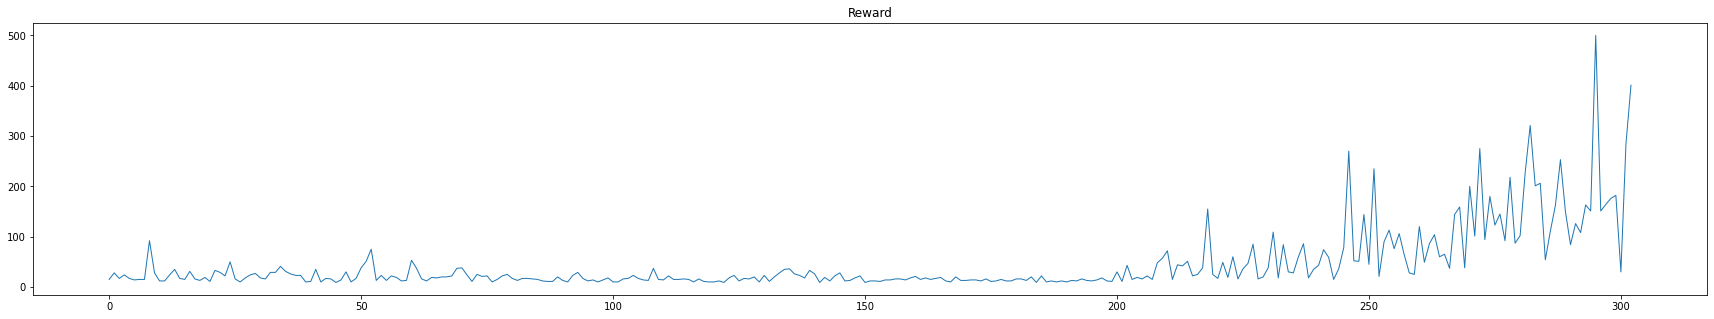

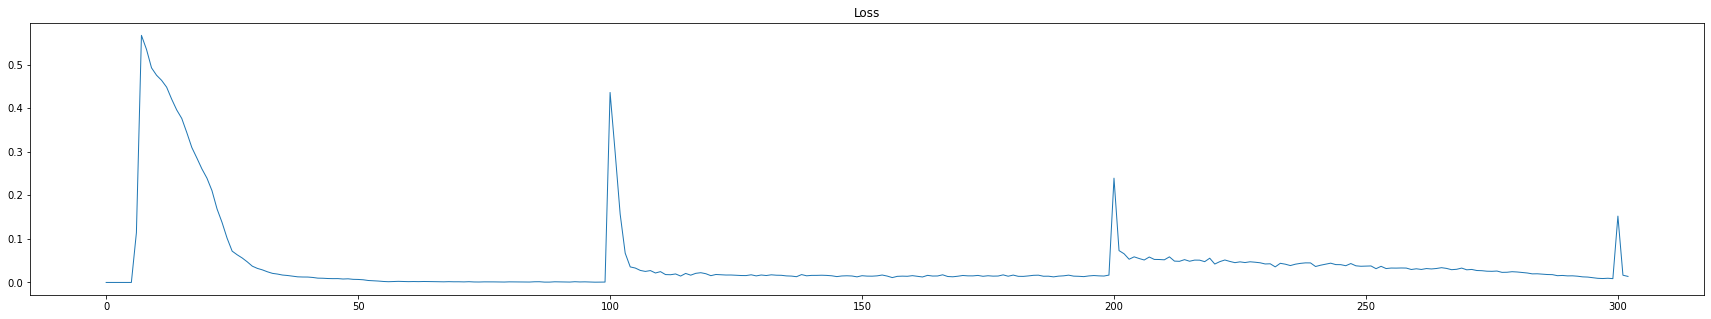

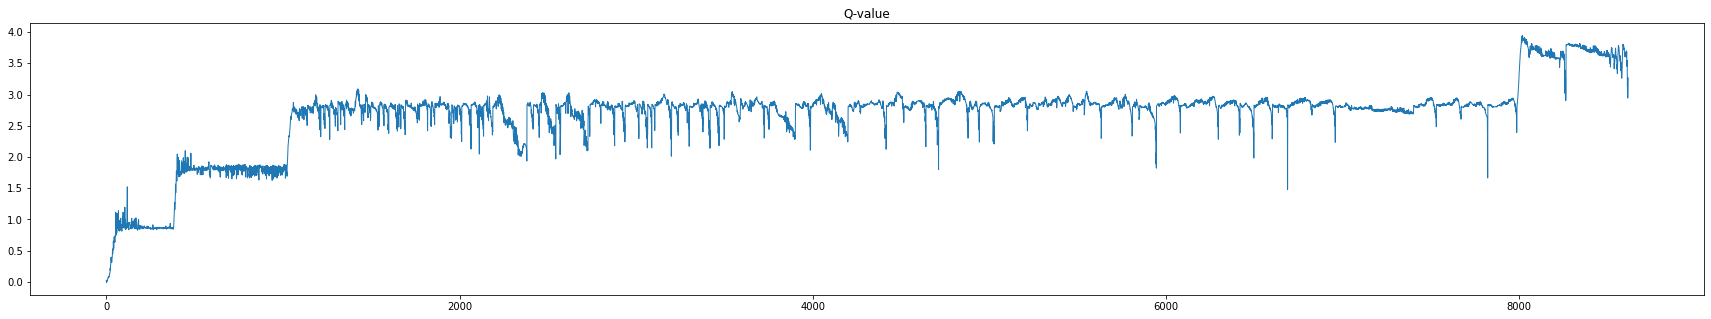

(None, None, None)

In [27]:
import matplotlib.pyplot as plt

def plot(data, title):
  plt.plot(data, linewidth=1)
  plt.rcParams["figure.figsize"] = (30, 5)
  plt.title(title)
  plt.show()

plot(complete_reward_history, 'Reward'), plot(complete_loss_history, 'Loss'), plot(complete_best_q_value_history, 'Q-value')

In [23]:
%%timeit
replay_memory = np.random.random((50000))
sorted(replay_memory)

10 loops, best of 5: 21.6 ms per loop
